In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [29]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias, physics_kernel_size):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                            out_channels=4 * self.hidden_dim,
                            kernel_size=self.kernel_size,
                            padding=self.padding,
                            bias=self.bias)

        self.physics_conv_x = nn.Conv2d(in_channels=self.input_dim,
                                        out_channels=self.hidden_dim,
                                        kernel_size=physics_kernel_size,
                                        padding=physics_kernel_size[0] // 2,
                                        bias=False)

        self.physics_conv_y = nn.Conv2d(in_channels=self.input_dim,
                                        out_channels=self.hidden_dim,
                                        kernel_size=physics_kernel_size,
                                        padding=physics_kernel_size[1] // 2,
                                        bias=False)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        # Check if input_tensor has an extra dimension (sequence length)
        if input_tensor.dim() == 5:
            input_tensor = input_tensor.squeeze(1)

        # Ensure the number of channels in input_tensor matches the input_dim
        if input_tensor.size(1) != self.input_dim:
            raise ValueError(f"Expected input_tensor to have {self.input_dim} channels, but got {input_tensor.size(1)} channels instead")

        # Ensure the number of channels in h_cur matches the hidden_dim
        if h_cur.size(1) != self.hidden_dim:
            raise ValueError(f"Expected h_cur to have {self.hidden_dim} channels, but got {h_cur.size(1)} channels instead")

        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)

        # Compute physics-based convolutions
        physics_conv_x = self.physics_conv_x(input_tensor)
        physics_conv_y = self.physics_conv_y(input_tensor)

        i = torch.sigmoid(cc_i + physics_conv_x)
        f = torch.sigmoid(cc_f + physics_conv_x)
        o = torch.sigmoid(cc_o + physics_conv_y)
        g = torch.tanh(cc_g + physics_conv_y)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, physics_kernel_size,output_dim,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias,
                                          physics_kernel_size=physics_kernel_size))

        self.cell_list = nn.ModuleList(cell_list)
        self.output_conv = nn.Conv2d(in_channels=hidden_dim[-1],
                                      out_channels=output_dim,
                                      kernel_size=1,
                                      padding=0)

    def forward(self, input_tensor, hidden_state=None):
        if input_tensor.dim() == 4:
            # (b, h, w, c) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(0, 3, 1, 2).unsqueeze(1)
        elif input_tensor.dim() == 5:
            if not self.batch_first:
                # (t, b, c, h, w) -> (b, t, c, h, w)
                input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, t, _, h, w = input_tensor.size()

        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        # Remove the sequence length dimension before applying the output convolution
        output = self.output_conv(layer_output_list[0].squeeze(1))
        # Permute the output to have shape (b, h, w, c)
        output = output.permute(0, 2, 3, 1)
        return output, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

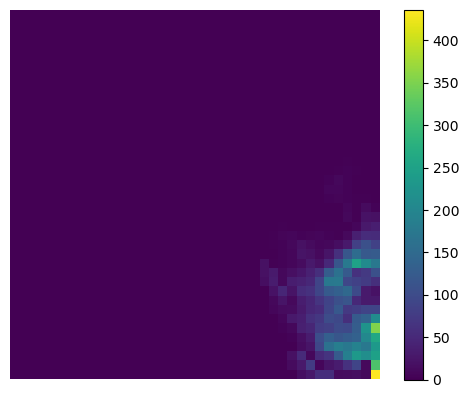

/home/sushen/anaconda3/envs/pinn/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


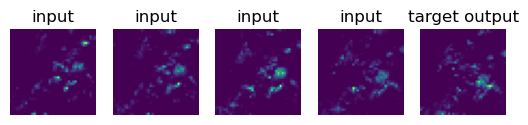

In [3]:
# load radar data
movies = np.load('data/radar_movies.npy')
movies.shape # (980, 40, 40, 20) -- here each movie is of length 20

# in our model we will use the first four images as inputs and predict the
# fifth image
x = movies[:, :, :,  :4]
y = movies[:, :, :, 4:5]


# function: animation of a sequence of radar data (shape = nx,ny,ntime)
def animate(x):
  fig, ax = plt.subplots()
  vmax = np.max(x)
  im = ax.imshow(x[:,:,0], vmin=0, vmax=vmax)
  fig.colorbar(im)
  plt.axis('off')
  def anim_(i):
      im.set_data(x[:,:,i])
      ax.set_title(str(i+1) + '/' + str(x.shape[2]))
  anim = animation.FuncAnimation(
      fig, anim_, interval=300, frames=x.shape[2], repeat_delay=1000)
  plt.show()

# i_plt = 340
# i_plt = 123
i_plt = np.int32(np.random.sample() * movies.shape[0])
animate(x[i_plt,:,:,:])
plt.show()

# train validate test split
tvt = np.tile(['train','train','train','validate','test'], y.shape[0])[:y.shape[0]]
x_train = x[np.where(tvt == 'train')]
y_train = y[np.where(tvt == 'train')]
x_validate = x[np.where(tvt == 'validate')]
y_validate = y[np.where(tvt == 'validate')]
x_test = x[np.where(tvt == 'test')]
y_test = y[np.where(tvt == 'test')]

n_test = x_test.shape[0]
i_plt = np.int32(np.random.sample() * n_test)
true = np.append(x_test[i_plt,:,:,:], y_test[i_plt,:,:,:], axis=2)
# plot an input/output pair
i_plt = 20
i_plt = np.int32(np.random.sample() * x_train.shape[0])
for jj in range(4):
  plt.subplot(1,5,jj+1)
  plt.imshow(x_train[i_plt,:,:,jj])
  plt.axis('off')
  plt.title('input')
plt.subplot(1,5,5)
plt.imshow(y_train[i_plt,:,:,0])
plt.title('target output')
plt.axis('off')
plt.show()

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



train_dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.from_numpy(x_validate).float(), torch.from_numpy(y_validate).float())
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the ConvLSTM model
input_dim = 4
hidden_dim = [64, 40]  # Use a list for multiple layers
kernel_size = [(3, 3), (3, 3)]  # Use a list for multiple layers
num_layers = 2
physics_kernel_size = (3, 3)  # Add physics kernel size

model = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, physics_kernel_size,output_dim=1, batch_first=True)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(batch_x)
        loss  = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)
    train_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            outputs, _ = model(batch_x)
            loss  = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_x.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Testing
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs, _ = model(batch_x)
        loss  = criterion(outputs, batch_y)
        test_loss += loss.item() * batch_x.size(0)
test_loss /= len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}")

Epoch [1/50], Train Loss: 951.4903, Val Loss: 1052.0746
Epoch [2/50], Train Loss: 920.4184, Val Loss: 1040.1132
Epoch [3/50], Train Loss: 910.2240, Val Loss: 1029.5301
Epoch [4/50], Train Loss: 900.5539, Val Loss: 1019.3830
Epoch [5/50], Train Loss: 891.3190, Val Loss: 1010.1618
Epoch [6/50], Train Loss: 882.8039, Val Loss: 1001.6610
Epoch [7/50], Train Loss: 874.6698, Val Loss: 992.9165
Epoch [8/50], Train Loss: 866.5691, Val Loss: 984.9666
Epoch [9/50], Train Loss: 859.2217, Val Loss: 977.1885
Epoch [10/50], Train Loss: 851.8154, Val Loss: 969.5283
Epoch [11/50], Train Loss: 844.7932, Val Loss: 962.1867
Epoch [12/50], Train Loss: 837.9083, Val Loss: 955.1505
Epoch [13/50], Train Loss: 831.3427, Val Loss: 948.9660
Epoch [14/50], Train Loss: 825.0639, Val Loss: 941.7428
Epoch [15/50], Train Loss: 818.5995, Val Loss: 935.4824
Epoch [16/50], Train Loss: 812.8250, Val Loss: 929.3328
Epoch [17/50], Train Loss: 806.7859, Val Loss: 922.9778
Epoch [18/50], Train Loss: 801.1531, Val Loss: 917.

In [33]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np
from IPython.display import Image
import os

def animate2(x1, x2,i_plt ,output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    vmax = np.max(np.append(x1, x2))
    vmin = np.min(np.append(x1, x2))

    frames = min(x1.shape[2], x2.shape[2])  # Get the minimum number of frames

    for i in range(frames):
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figure size as needed

        im1 = ax[0].imshow(x1[:, :, i], vmin=vmin, vmax=vmax)
        im2 = ax[1].imshow(x2[:, :, i], vmin=vmin, vmax=vmax)

        diff = x1[:, :, i] - x2[:, :, i]
        vmin_diff, vmax_diff = np.min(diff), np.max(diff)
        norm = mcolors.Normalize(vmin=vmin_diff, vmax=vmax_diff)
        im3 = ax[2].imshow(diff, cmap='viridis', norm=norm)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im3, cax=cbar_ax)

        # Add labels
        ax[0].set_title('Predicted')
        ax[1].set_title('True')
        ax[2].set_title('Difference')

        # Remove axis ticks
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        # Calculate MAE and RMSE for the current frame
        mae = np.mean(np.abs(diff))
        rmse = np.sqrt(np.mean(diff ** 2))

        # Add MAE and RMSE to the plot title
        fig.suptitle(f'ConvLSTM | i = {i_plt} Predicted Frame - MAE: {mae:.4f}, RMSE: {rmse:.4f}', fontsize=12)

        # Save the current frame as an image file
        filename = f'ConvLSTMframe_{i_plt:04d}_{i+1:04d}.png'
        filepath = os.path.join(output_folder, filename)
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        plt.close(fig)

        # Print MAE and RMSE for the current frame
        print(f'Frame {i+1} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    print(f"Images saved in the folder: {output_folder}")


# # Convert y_test to a PyTorch tensor
# y_test_tensor = torch.from_numpy(y_test).float()

# # Assuming your model is defined and trained
# model.eval()  # Set the model to evaluation mode
# y_test_pred = torch.empty_like(y_test_tensor)  # Initialize an empty tensor to store predictions

# with torch.no_grad():  # Disable gradient computation for inference
#     for i, (batch_x, batch_y) in enumerate(test_loader):
#         batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#         outputs = model(batch_x)  # Get the model outputs for this batch

#         # Check if the output is a list
#         if isinstance(outputs, list):
#             outputs = outputs[-1]  # Assuming the last element is the final output

#             # Check if the last element is a tensor
#             if isinstance(outputs, torch.Tensor):
#                 # Reshape the output to match the expected shape
#                 if len(outputs.shape) == 5:
#                     outputs = outputs.squeeze(2)  # Remove the singleton dimension

#                 y_test_pred[i * test_loader.batch_size:(i + 1) * test_loader.batch_size] = outputs  # Store the predictions
#             else:
#                 print(f"Warning: Unexpected output type for batch {i}: {type(outputs)}")

# # Now you have y_test_pred ready to use


# # Assuming x_test, y_test, and y_test_pred are PyTorch tensors
# n_test = x_test.shape[0]
# i_plt = np.int32(np.random.sample() * n_test)
# i_plt = 111
# print('Showing test case i =', i_plt)

# # Convert NumPy arrays to PyTorch tensors
# x_test_tensor = torch.from_numpy(x_test).float()
# y_test_tensor = torch.from_numpy(y_test).float()

# Repeat the channel dimension of y_test_tensor to match x_test_tensor


# print(f'shape of x test tensor: {x_test_tensor[i_plt].shape}')
# print(f'shape of y test tensor: {y_test_tensor[i_plt].shape}')
# print(f'shape of y test pred: {y_test_pred[i_plt].shape}')
# for i_plt in range(10):
#     true = np.append(x_test[i_plt,:,:,:], y_test[i_plt,:,:,:], axis=2)
#     pred = np.append(x_test[i_plt,:,:,:], y_test_pred[i_plt,:,:,:], axis=2)

#     anim = animate2(pred, true,'/home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot')


In [34]:
with torch.no_grad():
    for i_plt, (batch_x, batch_y) in enumerate(test_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass
        output, _ = model(batch_x)
        
        # Compute data loss
        data_loss = criterion(output, batch_y)

        # Combine losses
        loss = data_loss

        test_loss += loss.item() * batch_x.size(0)

        # Plot the results for the current batch
        for j in range(batch_x.size(0)):
            print(f'Batch {i_plt}, Sample {j}, batch_x.shape: {batch_x[j].shape}, batch_y.shape: {batch_y[j].shape}, output.shape: {output[j].shape}')
            true = np.append(batch_x[j].cpu().numpy(), batch_y[j].cpu().numpy(), axis=2)
            pred = np.append(batch_x[j].cpu().numpy(), output[j].cpu().numpy(), axis=2)
            anim = animate2(pred, true, i_plt * batch_x.size(0) + j, '/home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot')

Batch 0, Sample 0, batch_x.shape: torch.Size([40, 40, 4]), batch_y.shape: torch.Size([40, 40, 1]), output.shape: torch.Size([40, 40, 1])
Frame 1 - MAE: 0.0000, RMSE: 0.0000
Frame 2 - MAE: 0.0000, RMSE: 0.0000
Frame 3 - MAE: 0.0000, RMSE: 0.0000
Frame 4 - MAE: 0.0000, RMSE: 0.0000
Frame 5 - MAE: 6.5894, RMSE: 69.1889
Images saved in the folder: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot
Batch 0, Sample 1, batch_x.shape: torch.Size([40, 40, 4]), batch_y.shape: torch.Size([40, 40, 1]), output.shape: torch.Size([40, 40, 1])
Frame 1 - MAE: 0.0000, RMSE: 0.0000
Frame 2 - MAE: 0.0000, RMSE: 0.0000
Frame 3 - MAE: 0.0000, RMSE: 0.0000
Frame 4 - MAE: 0.0000, RMSE: 0.0000
Frame 5 - MAE: 6.4651, RMSE: 16.5229
Images saved in the folder: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot
Batch 0, Sample 2, batch_x.shape: torch.Size([40, 40, 4]), batch_y.shape: torch.Size([40, 40, 1]), output.shape: torch.Size([40, 40, 1])
Frame 1 - MAE: 0.0000, RMSE: 0.0000
Frame 2 - MAE: 0.0000